<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Decision Tree Classification</p>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>🧠 Algorithm Intuition:</font></h3>

<ul>
    <li><i>Decision Trees</i> make use of decision rules to split training examples in to sub groups based on whether they pass a Yes / No statement about a particular attribute (feature). Splitting can occur over and over again if necessary, aiming to reduce the uncertainty or impurity of the sub groups with respect to the group from which they split. There is no probabilistic element and as such, no traditional objective (loss) function exists to determine the best parameters of the model.</li> 
    <li>The first node in all trees is called the "root node". From there, all nodes that results from downstream splits are called "internal nodes". Finally, nodes no longer split are called "leaf nodes". The pseudocode for building a tree treats each node and its duaghter nodes as a tree in itself, layering them at each node to chain together trees in to a final fully-constructed tree. It can be seen as a construction loop, with the same reasoning being called again and again each node. This is as follows: 
<ul>

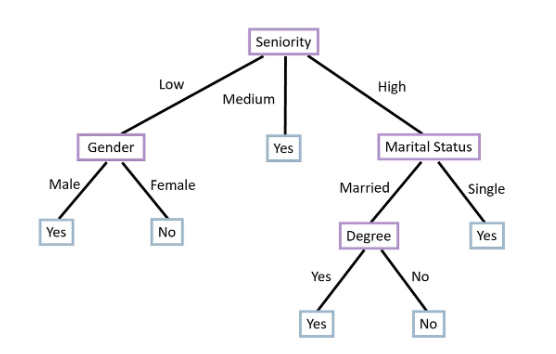
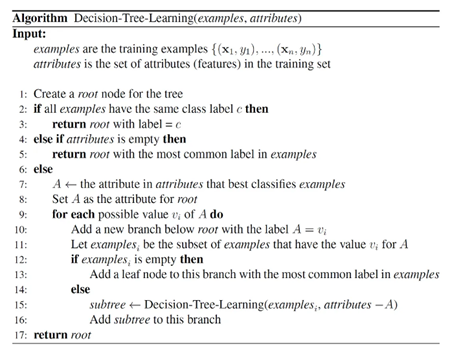

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>❔ Choosing Attributes for Splitting:</font></h3>

<ul>
    <li>To decide at each node which attribute to use for the split, the logic is simple. A good attribute splits the examples into purer subsets, i.e., subsets of the training examples are more homogenous in their class labels than when they were all together in their parent node.</li> 
    <li>Ideally, there is an attribute that splits into completely pure subsets. In many cases however, there must be a definition for "node impurity", a measure that will allow comparison of the quality of the splits of different attributes. Two approaches lead the field: <b>Entropy</b> and <b>Gini Index</b></li>
<ul>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>1. Entropy</font></h3>

<ul>
    <li>Entropy of a random variable is a measure of the uncertainty in its possible outcomes. The higher the uncertainty, the higher its entropy.</li>
    <li>With <i>p</i>(<i>xᵢ</i>)</i> being the probability of any given value of the random variate, the formula for entropy <i>H</i> is defined as below.</li>
    <li>The parallel of this to Decision Tree follows.</li>
<ul>

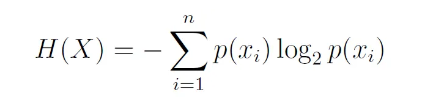
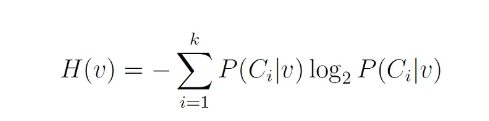

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>2. Gini Index</font></h3>

<ul>
    <li>As an alternative, "Gini Index" (or "Gini Impurity") measures how often a randomly chosen sample at a given node would be incorrectly labeled if it were labeled randomly according to the distribution of the classes at that node. With a more heterogenous class distribution, the probability of misclassification increases, as does its Gini index.</l>
    <li>With <i>pj</i> being the probability of any given class being mislabelled, the Gini index is computed by summing pairwise products of these probabilities for each class:</li>
<ul>

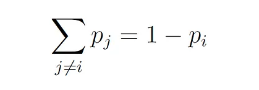
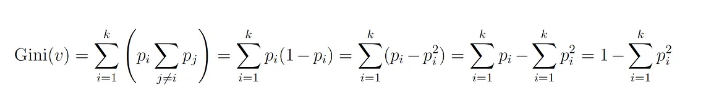

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💥 Information Gain:</font></h3>

<ul>
    <li>Information Gain is the goal of splitting. It measures the reduction in entropy / impurity at node <i>v</i> after splitting it into child nodes <i>v₁</i>, <i>v₂</i>, …, <i>vₖ</i>. In turn, each attribute is used to measure IG, the chosen one being the one with the highest IG. The formula is given below, as well as a worked example.</li>
<ul>

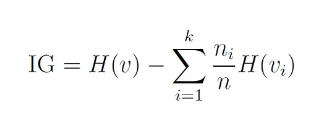

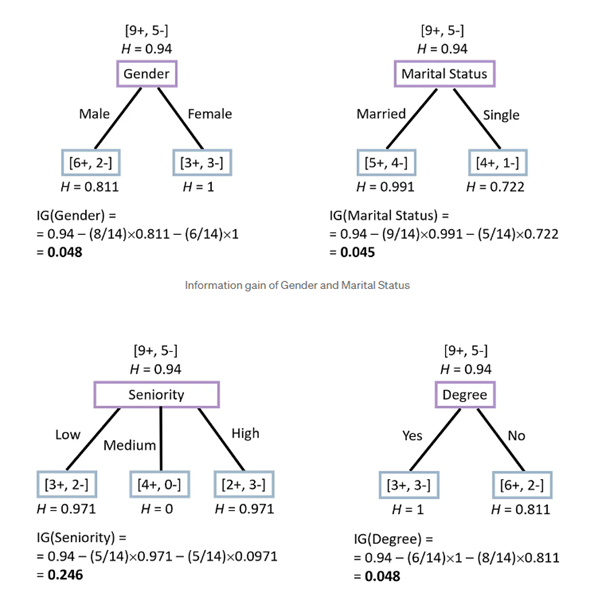

*Import Libraries*

In [2]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

In [3]:
# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Approach*
1. Load data
2. Split data
3. Create ColumnTransformer w/ ohe (so scaling needed)
4. Create DecisionTreeClassifier w/ default
5. Create pipeline w/ ColumnTransformer & DecisionTreeClassifier
6. Create and evaluate cross_val_score on pipeline
7. Compare train and test scores for baseline model (overfitting? Train likely ~ 100%)
8. Compare affect of different seeds on baseline model. Verify cross_val_score and test averages are similar
9. Create GridSearchCV with params 
10. Fit and evaluate best hyperparameters
11. Plot classification_report and confusion_matrix
12. Evaluate affect of balancing the class with smote or with class_weight="balanced"
13. Visualise the best performing model with sklearn.tree.plot_tree 
14. Select k most important features and evaluate re-run with just those


*Import data from initial EDA*

In [4]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [5]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43, stratify=y)

In [6]:
# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

In [7]:
# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [8]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [9]:
# create model
model_dt = DecisionTreeClassifier(random_state=42)  # criterion ='gini' ["gini", "entropy", "log_loss"]
                                                    # splitter = 'best' ["best", "random"]
                                                    # max_depth = None [int]
                                                    # min_samples_split = 2 [int or float]
                                                    # min_samples_leaf = 1 [int or float]
                                                    # min_weight_fraction_leaf = 0.0 [float]
                                                    # max_features = None [int or float or "auto", "sqrt", "log2"]
                                                    # --> random_state = None
                                                    # max_leaf_nodes = None [int]
                                                    # min_impurity_decrease = 0.0 [float]
                                                    # class_weight = None [dict, list of dict or "balanced"]
                                                    # ccp_alpha = 0.0 [float]

# create sklearn pipeline
pipeline_dt = settings.create_pipeline(["preprocess", column_trans], ["decision_tree_classification", model_dt])

# create cross validation object for cross_val_score
cv_dt = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# fit pipeline and produce train score 
pipeline_dt.fit(X_train, y_train)
train_acc = pipeline_dt.score(X_train, y_train)
print('Train Accuracy:', settings.score_formatter(train_acc, 4))

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_dt, X_train, y_train, scoring='accuracy', cv=cv_dt)
print('Mean CV Train Accuracy:', settings.score_formatter(np.mean(cv_scores), 4), 
      '(max:',  settings.score_formatter(np.max(cv_scores), 4),")",
      '(min:',  settings.score_formatter(np.min(cv_scores), 4),")",
      '(std:',  settings.score_formatter(np.std(cv_scores), 4),")")

# produce test score 
test_acc = pipeline_dt.score(X_test, y_test)
print('Test Accuracy:', settings.score_formatter(test_acc, 4))

Train Accuracy: 93.4900 %
Mean CV Train Accuracy: 87.2200 % (max: 94.2300 % ) (min: 75.0000 % ) (std: 4.2600 % )
Test Accuracy: 83.1900 %


Average train score across seeds: 93.500 %
Average cv train score across seeds: 87.000 %
Average test score across seeds: 88.000 %


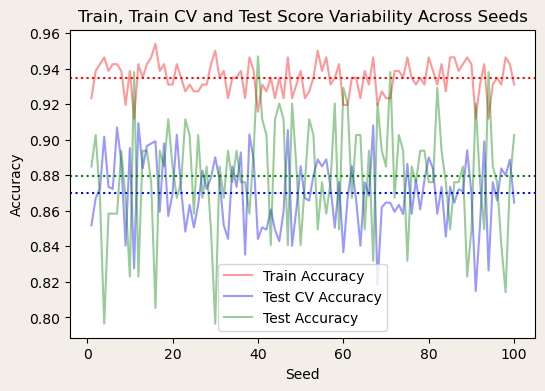

In [10]:
# Visualise averages across many seeds
settings.plot_seed_variability(X=X, y=y, test_size=0.3, num_seeds=100, pipeline_or_model=pipeline_dt, scoring="accuracy", cv_object=cv_dt)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Descent baseline model train cv accuracy ~ 87% and test accuracy ~83%</li>
    <li>Slightly more out-of-the-box overfitting compared to other models but not much</li>
</ul>
</div>


In [11]:
# Save baseline pipeline to file  
settings.save_pipeline("best_decision_tree_classification_pipeline.pkl", pipeline_dt)

*Hyperparam tuning*

*Impurity and split method*

In [13]:
# set up param grid
param_grid_dt = {
    'decision_tree_classification__criterion': ["gini", "entropy"],
    'decision_tree_classification__splitter': ["best", "random"], 
    # 'decision_tree_classification__max_depth': [None, 3, 5, 7],
    # 'decision_tree_classification__min_samples_split': [1, 5, 10],
    # 'decision_tree_classification__min_samples_leaf': [2, 5, 10],
#    'decision_tree_classification__min_weight_fraction_leaf': [0.0],
#    'decision_tree_classification__max_features': ["auto", "sqrt", "log2"],
    # 'decision_tree_classification__max_leaf_nodes': [None, 5, 10],
    # 'decision_tree_classification__min_impurity_decrease': [0.0, 0.01, 0.05]
#    'decision_tree_classification__class_weight': [None]
#    'decision_tree_classification__ccp_alpha': [0.0]
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring='accuracy', cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Access best hyperparameters and accuracy score
best_params, best_train_score = grid_search_dt.best_params_, grid_search_dt.best_score_

# Print the best parameters
display("Best Parameters:", pd.DataFrame(best_params, index=[0]))

# Print the best mean cv training score
print("Mean CV Train Accuracy with best parameters:", settings.score_formatter(best_train_score, 4))

# Evaluate the best model on the test set
best_pipeline = grid_search_dt.best_estimator_
test_accuracy = best_pipeline.score(X_test, y_test)
print("Test Accuracy with best parameters:", settings.score_formatter(test_accuracy, 4))

'Best Parameters:'

,decision_tree_classification__criterion,decision_tree_classification__splitter
0,entropy,random


Mean CV Train Accuracy with best parameters: 87.6000 %
Test Accuracy with best parameters: 83.1900 %


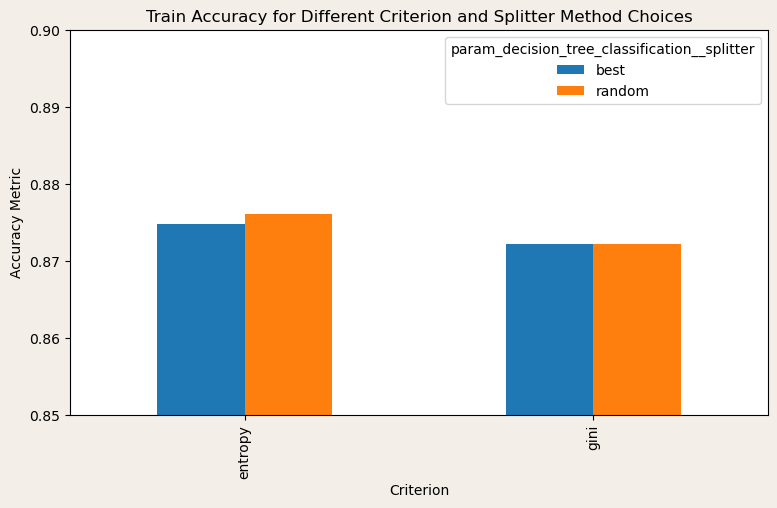

In [17]:
# Access the grid search results
results = grid_search_dt.cv_results_

# Extract k values, weights values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped.groupby(["param_decision_tree_classification__criterion", "param_decision_tree_classification__splitter"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.85, 0.9)
ax.set_xlabel('Criterion')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different Criterion and Splitter Method Choices')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Criterion of entropy slightly higher than gini (~0.3%)</li>
    <li>When entropy chosen, random split slightly performs slightly better. This is where the split point for all attributes is randomly chosen (only for the continuous columns) rather than exhaustively finding the best threshold for the split point. The additional randomness introduced means that the same attribute will not always be chosen to split nodes in the tree and hense potentially more generalisability for unseen data is allowed. However, the difference is very minor. (~0.2%)</li>
</ul>
</div>


*Pre pruning and split method*

In [ ]:
# refine model
model_dt = DecisionTreeClassifier(criterion = "entropy", splitter = "random", random_state=42)  # --> criterion ='gini' ["gini", "entropy", "log_loss"]
                                                                                                # --> splitter = 'best' ["best", "random"]
                                                                                                # max_depth = None [int]
                                                                                                # min_samples_split = 2 [int or float]
                                                                                                # min_samples_leaf = 1 [int or float]
                                                                                                # min_weight_fraction_leaf = 0.0 [float]
                                                                                                # max_features = None [int or float or "auto", "sqrt", "log2"]
                                                                                                # --> random_state = None
                                                                                                # max_leaf_nodes = None [int]
                                                                                                # min_impurity_decrease = 0.0 [float]
                                                                                                # class_weight = None [dict, list of dict or "balanced"]
                                                                                                # ccp_alpha = 0.0 [float]

# create sklearn pipeline
pipeline_dt = settings.create_pipeline(["preprocess", column_trans], ["decision_tree_classification", model_dt])
# set up param grid
param_grid_dt = {
    'decision_tree_classification__criterion': ["gini", "entropy"],
    'decision_tree_classification__splitter': ["best", "random"], 
    # 'decision_tree_classification__max_depth': [None, 3, 5, 7],
    # 'decision_tree_classification__min_samples_split': [1, 5, 10],
    # 'decision_tree_classification__min_samples_leaf': [2, 5, 10],
#    'decision_tree_classification__min_weight_fraction_leaf': [0.0],
#    'decision_tree_classification__max_features': ["auto", "sqrt", "log2"],
    # 'decision_tree_classification__max_leaf_nodes': [None, 5, 10],
    # 'decision_tree_classification__min_impurity_decrease': [0.0, 0.01, 0.05]
#    'decision_tree_classification__class_weight': [None]
#    'decision_tree_classification__ccp_alpha': [0.0]
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring='accuracy', cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Access best hyperparameters and accuracy score
best_params, best_train_score = grid_search_dt.best_params_, grid_search_dt.best_score_

# Print the best parameters
display("Best Parameters:", pd.DataFrame(best_params, index=[0]))

# Print the best mean cv training score
print("Mean CV Train Accuracy with best parameters:", settings.score_formatter(best_train_score, 4))

# Evaluate the best model on the test set
best_pipeline = grid_search_dt.best_estimator_
test_accuracy = best_pipeline.score(X_test, y_test)
print("Test Accuracy with best parameters:", settings.score_formatter(test_accuracy, 4))

'Best Parameters:'

,decision_tree_classification__criterion,decision_tree_classification__splitter
0,entropy,random


Mean CV Train Accuracy with best parameters: 87.6000 %
Test Accuracy with best parameters: 83.1900 %
